In [ ]:
!pip install fastai

In [ ]:
import fastai
fastai.__version__

'2.0.0'

In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = 'drive/My Drive/thesis'

**Load the ratings**

In [ ]:
ratings = pd.read_csv(path + '/data/final.csv', header=0)
ratings.head()

,user,item,overall
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0


In [ ]:
# This block of code is used to read data from gzip.json file.
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# get df from gzip file
def get_df(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

**Get products' name**

In [ ]:
product_details = get_df(path + '/data/json_part/products_full.gz')

In [ ]:
product_details['title']

0         Kelby Training DVD: Mastering Blend Modes in Adobe Photoshop CS5 By Corey Barker
1                  Kelby Training DVD: Adobe Photoshop CS5 Crash Course By Matt Kloskowski
2                                                          Digital Organizer and Messenger
3                                      CLIKR-5 Time Warner Cable Remote Control UR5U-8780L
4                             Rand McNally 528881469 7-inch Intelliroute TND 700 Truck GPS
                                                ...                                       
498191                                                                   Suction Cup Mount
498192                                                      Parallel PCMCIA Card 1PORT Epp
498193                                          C2G / Cables to Go 5M Ultima USB 2.0 Cable
498194                                                           Underdesk Keyboard Drawer
498195                                                         USB To R232 Converter Cable

In [ ]:
product_details.to_csv(path + '/data/product_detail.csv', index=False)

**Convert username and asin to ids**

In [ ]:
ratings_full = ratings.copy()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
ratings_full['userId'] = None
ratings_full['itemId'] = None
ratings_full[['userId', 'itemId']] = enc.fit_transform(ratings_full[['user', 'item']])

enc.categories_

[array(['A100UD67AHFODS', 'A100WO06OQR8BQ', 'A105S56ODHGJEK', ...,
        'AZMY6E8B52L2T', 'AZNUHQSHZHSUE', 'AZOK5STV85FBJ'], dtype=object),
 array(['0594451647', '0594481813', '0970407998', ..., 'B00LGQ6HL8',
        'B00LI4ZZO8', 'B00LKG1MC8'], dtype=object)]

In [ ]:
ratings_full_copy = ratings_full.copy()

In [ ]:
# Convert to int32
ratings_full_copy[['userId', 'itemId']] = ratings_full_copy[['userId', 'itemId']].astype('int32')

In [ ]:
ratings_full_copy['title'] = product_details.loc[product_details['asin'].isin(ratings_full_copy['item'])]['title']

In [ ]:
ratings_full_copy['item'].nunique(), ratings_full_copy['title'].nunique()

(48190, 18132)

In [ ]:
# Re-order columns
cols = ['userId', 'itemId', 'overall', 'title']
final = ratings_full_copy[cols].copy()

In [ ]:
dls = CollabDataLoaders.from_df(final, item_name='title', bs=64)

In [ ]:
dls.show_batch()

,userId,title,overall
0,123,#na#,2.0
1,0,#na#,4.0
2,1157,#na#,2.0
3,69,#na#,5.0
4,1279,#na#,5.0
5,1022,#na#,5.0
6,84,#na#,5.0
7,873,"Exquisite Womens Designer Briefcase Laptop, Tablet, Ipad Bag",5.0
8,1270,#na#,4.0
9,205,#na#,2.0


In [ ]:
learn = collab_learner(dls, n_factors=5, y_range=(0.,5.))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.394261,1.367918,00:12
1,1.247938,1.269919,00:12
2,1.187054,1.242340,00:12
3,1.174814,1.234882,00:12
4,1.130564,1.234351,00:12


In [ ]:
g = ratings_full_copy.groupby('title')['overall'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['SwissGear Computer Backpack (Black)',
       'SwissGear Computer Backpack (Red)', 'Logitech EasyCall Desktop',
       'TP-LINK TL-SF1005D 5-port 10/100Mbps Desktop Switch',
       'RiteAV - Cat5e Network Ethernet Cable - Blue - 200 ft.',
       'Bluetooth USB 2.0 Micro Adapter Dongle',
       '1-Year Replacement Plan for Electronics Products',
       'Belkin A3L791-S 25-Foot RJ45 CAT 5e Snagless Molded Patch Cable (Gray)',
       '1.3MP Digital Camera', 'Lexar Media 128 MB Memory Stick'],
      dtype=object)

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = ratings_full_copy.groupby('title')['overall'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

**Worst bias**

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.0674),
  'HDMI to DVI Cable, HDMI Male to DVI Male, CL2 rated, 15 foot',
  2.0),
 (tensor(-0.0672), 'HP Foldable Keyboard - Keyboard', 1.0),
 (tensor(-0.0667),
  'Garmin n&uuml;vi 680 4.3-Inch Bluetooth Portable GPS Navigator',
  1.0),
 (tensor(-0.0665),
  'Hoya 77mm UV (Ultra Violet) Multi Coated Glass Filter',
  1.0),
 (tensor(-0.0658),
  'Garmin Colorado 300 Bilingual Handheld GPS Unit with North American Maps',
  2.0),
 (tensor(-0.0651), 'HP MV2010 Media Vault 300 GB External Hard Drive', 1.0),
 (tensor(-0.0650), 'Giottos MM9780 5-Section Aluminum Monopod', 1.0),
 (tensor(-0.0647), 'HDMI Cable Category 2, Full 1080P Capable (6 Feet)', 1.0),
 (tensor(-0.0631),
  'HDMI 2M (6 Feet) Super High Resolution Cable by Abacus24-7',
  1.0),
 (tensor(-0.0630), 'HP  A716 Photosmart Compact Photo Printer', 1.0),
 (tensor(-0.0630),
  'Hoya 77mm DMC PRO1 Digital ND8X (0.9) Neutral Density Filter',
  2.0),
 (tensor(-0.0630),
  'Hoya 55mm Circular Polarizer (G SERIES) PL CIR Filter',
  1

**Best bias**

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.1226), 'Motorola MOTOROKR EQ3 Compact Folding Speaker', 5.0),
 (tensor(0.1189), 'Lexar Media 128 MB Memory Stick', 4.5),
 (tensor(0.1187), 'SanDisk Sansa Clip 2 GB MP3 Player (Red)', 5.0),
 (tensor(0.1167),
  'Sylvania 1 GB Sport Style MP3 Player with Rubber Finish',
  4.5),
 (tensor(0.1166), 'Microsoft Wired Keyboard 500', 5.0),
 (tensor(0.1159),
  'Mirage Os3-Sat Premium Omnipolar Satellite-Bookshelf Speaker (Discontinued by Manufacturer)',
  5.0),
 (tensor(0.1137),
  'Apple iPod touch 16 GB (1st Generation)  (Discontinued by Manufacturer)',
  5.0),
 (tensor(0.1080), 'Logitech EasyCall Desktop', 4.5),
 (tensor(0.1079), 'Microsoft Wheel Mouse Optical', 5.0),
 (tensor(0.1076), 'Audio/Video Cable', 5.0),
 (tensor(0.1054),
  'RiteAV - Cat5e Network Ethernet Cable - Blue - 200 ft.',
  5.0),
 (tensor(0.1049),
  'Belkin A3L791-S 25-Foot RJ45 CAT 5e Snagless Molded Patch Cable (Gray)',
  3.5),
 (tensor(0.1047), '1.3MP Digital Camera', 5.0),
 (tensor(0.1013), 'Apple USB Power Adapt

**Weights**

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 5])

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.2006), 'Motorola MOTOROKR EQ3 Compact Folding Speaker'),
 (tensor(0.1943),
  'Mirage Os3-Sat Premium Omnipolar Satellite-Bookshelf Speaker (Discontinued by Manufacturer)'),
 (tensor(0.1926), 'SanDisk Sansa Clip 2 GB MP3 Player (Red)'),
 (tensor(0.1829), 'Microsoft Wired Keyboard 500'),
 (tensor(0.1651), 'Logitech EasyCall Desktop'),
 (tensor(0.1642), '1.3MP Digital Camera'),
 (tensor(0.1638), 'RiteAV - Cat5e Network Ethernet Cable - Blue - 200 ft.'),
 (tensor(0.1590), 'Microsoft Wheel Mouse Optical'),
 (tensor(0.1526), 'Audio/Video Cable'),
 (tensor(0.1392), 'Apple USB Power Adapter for iPod (White)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.2197), 'HP Foldable Keyboard - Keyboard'),
 (tensor(-0.2182), 'HP MV2010 Media Vault 300 GB External Hard Drive'),
 (tensor(-0.2179), 'Giottos MM9780 5-Section Aluminum Monopod'),
 (tensor(-0.2158),
  'Garmin Colorado 300 Bilingual Handheld GPS Unit with North American Maps'),
 (tensor(-0.2145), 'Hoya 55mm Circular Polarizer (G SERIES) PL CIR Filter'),
 (tensor(-0.2137), 'HDMI Cable Category 2, Full 1080P Capable (6 Feet)'),
 (tensor(-0.2132),
  'HDMI 2M (6 Feet) Super High Resolution Cable by Abacus24-7'),
 (tensor(-0.2123), 'HP  A716 Photosmart Compact Photo Printer'),
 (tensor(-0.2120), 'Hoya 77mm UV (Ultra Violet) Multi Coated Glass Filter'),
 (tensor(-0.2117),
  'HP TX2-1020US TouchSmart 12.1-Inch Laptop (2.2 GHz AMD Turion X2 Ultra ZM-82 Dual-Core Mobile Processor, 4 GB RAM, 320 GB Hard Drive, Vista Premium)')]

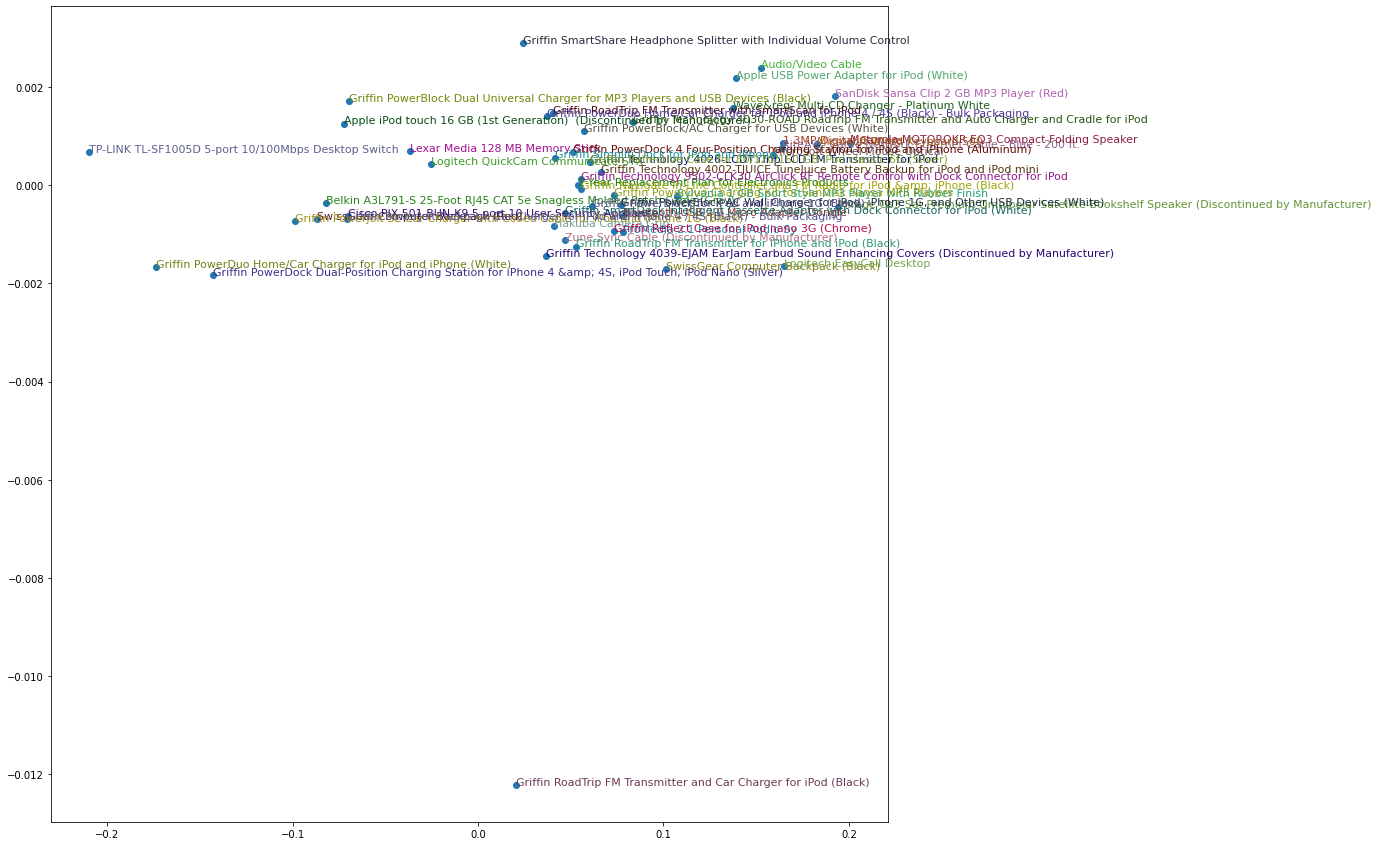

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()